## Notes sur le laboratoire

### Utilisation de commandes

Dans ce laboratoire, il est parfois intéressant (mais pas nécessaire à strictement parler) d'entrer certaines commandes dans le terminal (ou ligne de commande). Dans l'explorateur de fichiers de Jupyter Notebook, il est très simple d'ouvrir un terminal via le menu New (ou Nouveau):

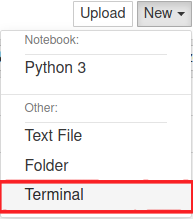

Par contre, il n'est malheureusement pas possible d'obtenir un terminal si Google Colab est utilisé.

### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to c:\users\gince\appdata\local\temp\pip-req-build-xanvqzrw


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git clone -q https://github.com/ulaval-damas/glo4030-labs.git 'C:\Users\Gince\AppData\Local\Temp\pip-req-build-xanvqzrw'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


# Laboratoire 1: Introduction à PyTorch

Le but de ce laboratoire est de se familiariser avec PyTorch en l'utilisant pour faire de la classification sur deux jeux de données connus: MNIST et CIFAR-10. On aura donc une vue d'ensemble de l'utilisation de PyTorch. Prenez donc le temps de lire le code et d'essayer de comprendre en haut niveau ce qui se passe.

La cellule ci-dessous importe les différents modules qui sont utilisés dans ce notebook. Notamment, en plus de différents modules de PyTorch (torch.\*), on importe deeplib qui est une libraire écrite spécialement pour les notebook de ce cours.

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 150

from deeplib.datasets import load_mnist, load_cifar10, train_valid_loaders
from sklearn.metrics import accuracy_score
from deeplib.net import MnistNet, CifarNet
from deeplib.history import History
from deeplib.visualization import plot_images

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## MNIST

MNIST est un jeu de données contenant des images de chiffres manuscrits.

Le jeu de données est séparé comme suit: 50 000 images sont utilisées en entraînement et 10 000 en test.

Pour obtenir les objets [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) de PyTorch pour les exemples d'entraînement et de test, on utilise la fonction `load_mnist` dans deeplib qui utilise la librairie [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) sous le capot.

In [3]:
mnist, mnist_test = load_mnist()

### Visualisation du jeu de données

Exécuter cette cellule plusieurs fois pour visualiser différents exemples du jeu de données.

La fonction `plot_images` est une fonction venant de deeplib.

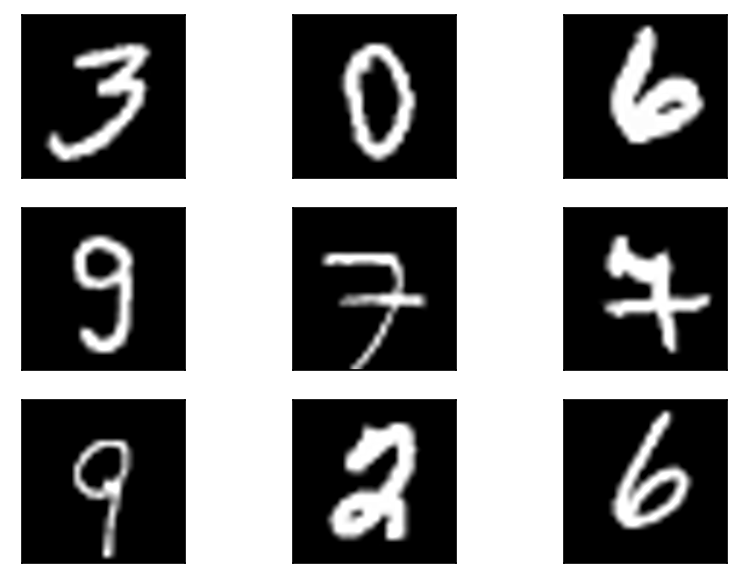

In [4]:
idx = random.sample([x for x in range(len(mnist))], 9)
images = [np.array(mnist[i][0]) for i in idx]
targets = [mnist[i][1] for i in idx]

plot_images(images, targets, gray=True)

On peut indexer les datasets de PyTorch comme une liste. Généralement, chaque élément d'un dataset va être un tuple `(x, y)`. Le terme `x` va correspondre à notre exemple. Le terme `y` va correspondre à notre étiquette (ou label, target) sous forme d'index (par exemple, on pourrait avoir 0 pour chien et 1 pour chat si on cherchait à différencier des images de chats et de chien). Avec MNIST, `x` sera les pixels de l'image et `y` sera le chiffre à classifier.

Les cellules ci-dessous affichent le premier élément `(x, y)` du jeu de données.

In [5]:
x, y = mnist[0]
x, y

(<PIL.Image.Image image mode=L size=28x28 at 0x1E5F0FD42B0>, 5)

On affiche l'image `x`.

In [6]:
x

On affiche l'étiquette `y`.

In [7]:
y

5

Les datasets de torchvision ont un attribut permettant d'effectuer une transformation sur nos images. Dans notre cas, on veut simplement obtenir un tenseur pour PyTorch.

In [8]:
mnist.transform = ToTensor()
mnist_test.transform = ToTensor()

## Entraînement

Pour l'entraînement, on a besoin d'une fonction ``train`` pour entraîner le réseau, d'une fonction ``validate`` pour estimer la performance de notre modèle au fur et à mesure de l'optimisation et d'une fonction ``test`` pour estimer la performance de notre modèle sur des données jamais observées.

Pour chaque epoch, la fonction ``train`` passe au travers de toutes les images du jeu de données dans un ordre aléatoire et met à jour les poids du réseau selon la perte calculée.<br>
Pour entraîner le réseau, la fonction doit recevoir 3 hyperparamètres: 
1. le nombre d'epochs qui indique combien de fois toutes les images du jeu de données seront observées; 
2. la taille de la batch qui indique combien d'images seront traitées à la fois;
3. le taux d'apprentissage qui détermine la vitesse à laquelle chaque poids du réseau sera modifié.

Pendant l'entraînement, une partie des données est utilisée pour créer un ensemble de validation qui permet d'estimer les performances de généralisation du modèle.

Finalement, on sauvegarde aussi quelques informations importantes afin de visualiser ce qui se passe pendant l'entraînement.

Le code est commenté pour donner plus de détails du déroulement de l'entraînement et des subtilités de PyTorch. Vous aurez l'occasion dans les prochains laboratoires de mieux comprendre tous ces détails.

In [9]:
def train(model, dataset, n_epoch, batch_size, learning_rate, use_gpu=False):
    """
    Entraîne un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        n_epoch (int): Le nombre d'epochs.
        batch_size (int): La taille des batchs.
        learning_rate (float): Le taux d'apprentissage pour SGD.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    
    Returns:
        Retourne un objet History permettant de faire des graphiques
        de l'évolution de l'entraînement.
    """
    # La classe History vient de deeplib. Elle va nous permettre de faire les graphiques
    # donnant l'évolution de la perte et de l'exactitude (accuracy).
    history = History()
    
    # La fonction de perte que nous utilisons ici est l'entropy croisée
    # L'optimiseur que nous utilisons ici est le classique SGD.
    # Des liens vers la documentation de PyTorch sont en commentaires.
    criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
    
    # La fonction train_valid_loaders vient de deeplib. Elle nous retourne deux DataLoaders:
    # un pour l'ensemble d'entraînement et un pour l'ensemble de test. Essentiellement,
    # DataLoader est une classe de PyTorch nous permettant de faire des batchs avec la taille
    # désirée. La fonction train_valid_loaders effectue la répartition aléatoire des exemples
    # en entraînement et en validation.
    train_loader, valid_loader = train_valid_loaders(dataset, batch_size=batch_size)

    # C'est ici que la boucle d'entraînement commence. On va donc faire n_epochs epochs.
    for i in range(n_epoch):
        # Les réseaux de neurones avec PyTorch ont un méthode train() en plus d'une méthode 
        # eval(). Ces deux méthodes indiquent au réseau s'il est en entraînement ou bien en test.
        # Ceci permet au réseau de modifier son comportement en fonction. On va le voir plus tard
        # certaines couches agissent différemment selon le mode, nommément le dropout et la 
        # batch normalization.
        model.train()
        
        # La prochaine ligne active simplement le calcul du gradient. Le gradient est ce qui va
        # nous permettre de mettre à jour les poids du réseau de neurones. En test, le calcul du
        # gradient sera désactivé étant qu'il n'est pas nécessaire et qu'il peut engendrer des 
        # fuites de mémoire si la rétro-propagation n'est pas effectuée.
        with torch.enable_grad():
            # À chaque epoch, on parcourt l'ensemble d'entraînement au complet via le DataLoader
            # qui nous le retourne en batch (x, y) comme mentionné plus haut. La variable inputs 
            # correspond donc à une batch d'exemples (x) et targets correspond à une batch 
            # d'étiquettes (y).
            for inputs, targets in train_loader:
                # On envoie les exemples et leurs étiquettes sur GPU via la méthode cuda() si 
                # demandé.
                if use_gpu:
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                # La méthode zero_grad() de l'optimiseur permet de mettre la valeur du gradient
                # à zéro de façon à effacer le gradient calculé auparavant. Si ceci n'était pas 
                # fait, le nouveau gradient serait additionné à l'ancien gradient ce qui poserait
                # problème.
                optimizer.zero_grad()
                
                # C'est ici que finalement le réseau de neurones est appelé. On lui donne en entrée
                # un exemple et en sortie il nous donne ses prédictions (ici, des scores de 
                # classification).
                output = model(inputs)

                # Une fois nos prédictions obtenues, on calcule la perte avec la fonction de perte 
                # qui nous retourne un tenseur scalaire. 
                loss = criterion(output, targets)
                # Ce tenseur scalaire nous permet de calculer le gradient. C'est ce que la méthode
                # backward() vient faire pour nous via la rétropropagation.
                loss.backward()
                # Une fois que le gradient est calculé, il ne reste que mettre à jour les poids du
                # réseau de neurones. C'est ce que la méthode step() de l'optimiseur vient faire
                # pour nous.
                optimizer.step()

        # Après chaque epoch d'entraînement, on va venir calculer la perte et l'exactitude 
        # (accuracy) sur l'ensemble d'entraînement et de validation.
        train_acc, train_loss = validate(model, train_loader, use_gpu)
        val_acc, val_loss = validate(model, valid_loader, use_gpu)
        history.save(dict(acc=train_acc, val_acc=val_acc, loss=train_loss, val_loss=val_loss, lr=learning_rate))
        print(f'Epoch {i} - Train acc: {train_acc:.2f} - Val acc: {val_acc:.2f} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}')

    return history

Pour chaque image du jeu de donnée, la fonction ``validate`` fait prédire une classe au réseau entraîné et compare le résultat avec la vraie réponse. Elle retourne le pourcentage de réponse correcte (c'est-à-dire l'exactitude, ou *accuracy* en anglais) ainsi que la perte moyenne.

In [10]:
def validate(model, valid_loader, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        valid_loader (DataLoader): Un DataLoader PyTorch tel qu'instancié dans train() 
            et test().
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
            
    Returns:
        Retourne un tuple (exactitude, perte) pour les données du DataLoader en argument.
    """
    
    # Les étapes de la fonction validate est très similaire à celle de la fonction train.
    # Essentiellement, le réseau est mis en mode évaluation au lieu d'entraînement et le 
    # calcul du gradient est désactivé. Il n'y a bien sûr pas d'utilisation d'un optimiseur.
    true = []
    pred = []
    val_loss = []
    
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            if use_gpu:
                inputs = inputs.cuda()
                targets = targets.cuda()

            output = model(inputs)

            predictions = output.max(dim=1)[1]

            val_loss.append(criterion(output, targets).item())
            true += targets.cpu().numpy().tolist()
            pred += predictions.cpu().numpy().tolist()

    return accuracy_score(true, pred) * 100, sum(val_loss) / len(val_loss)

La fonction `test` est utilisée à la fin de l'entraînement sur l'ensemble de test et affiche le pourcentage de réponse correcte ainsi que la perte moyenne sur cet ensemble.

In [11]:
def test(model, dataset, batch_size, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch. La fonction affiche l'exactitude et la perte moyenne.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        batch_size (int): La taille des batchs.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    """
    test_loader = DataLoader(dataset, batch_size=batch_size)
    test_acc, test_loss = validate(model, test_loader, use_gpu=use_gpu)
    print('Test acc: {:.2f} - Test loss: {:.4f}'.format(test_acc, test_loss))
    return test_acc, test_loss

Entraînons un modèle.

In [12]:
model = MnistNet()
print(torch.cuda.is_available())
model.cuda()

n_epoch = 10
batch_size = 64
learning_rate = 0.1

history = train(model, mnist, n_epoch, batch_size, learning_rate, use_gpu=True)

True
Epoch 0 - Train acc: 96.52 - Val acc: 96.16 - Train loss: 0.1107 - Val loss: 0.1181
Epoch 1 - Train acc: 97.97 - Val acc: 97.39 - Train loss: 0.0678 - Val loss: 0.0779
Epoch 2 - Train acc: 98.34 - Val acc: 97.97 - Train loss: 0.0519 - Val loss: 0.0654
Epoch 3 - Train acc: 98.99 - Val acc: 98.49 - Train loss: 0.0316 - Val loss: 0.0460
Epoch 4 - Train acc: 99.22 - Val acc: 98.70 - Train loss: 0.0265 - Val loss: 0.0405
Epoch 5 - Train acc: 99.38 - Val acc: 98.77 - Train loss: 0.0214 - Val loss: 0.0374
Epoch 6 - Train acc: 99.34 - Val acc: 98.63 - Train loss: 0.0211 - Val loss: 0.0422
Epoch 7 - Train acc: 99.56 - Val acc: 98.88 - Train loss: 0.0147 - Val loss: 0.0388
Epoch 8 - Train acc: 99.57 - Val acc: 98.89 - Train loss: 0.0136 - Val loss: 0.0382
Epoch 9 - Train acc: 99.80 - Val acc: 99.06 - Train loss: 0.0071 - Val loss: 0.0332


En utilisant la méthode `display` de la classe `History`, on peut visualiser l'entraînement précédent.

Le premier graphique montre l'évolution de l'exactitude (accuracy) du modèle sur le jeu de données d'entraînement et sur celui de validation. Le deuxième montre la perte sur les deux jeux de données.

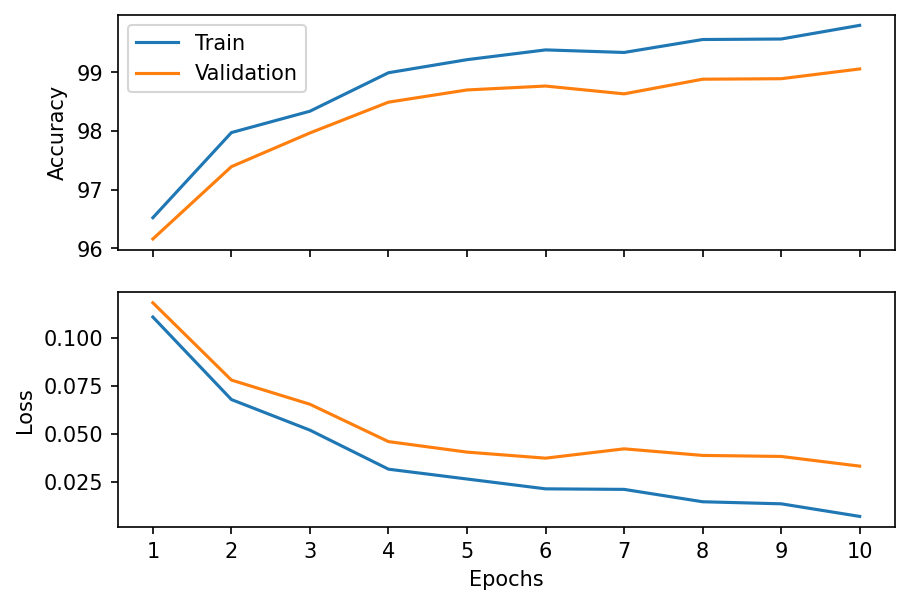

In [13]:
history.display()

Finalement, évaluons les performances du modèle sur le jeu de données de test.

In [14]:
test(model, mnist_test, batch_size, use_gpu=True)

Test acc: 99.13 - Test loss: 0.0306


(99.13, 0.030561198466752985)

## Différences CPU - GPU

Pour faire exécuter le code sur GPU, il faut déplacer le model, les inputs et les targets sur le GPU. 

Le réseau contient deux couches de convolutions qui servent à extraire des caractéristiques des images tandis que les couches linéaires servent de classifieur. Il s'agit d'un pipeline commun pour toutes les classes.

In [15]:
model_gpu = MnistNet()
model_gpu.cuda()

MnistNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Comparons le temps d'exécution sur CPU et sur GPU. Pour ce faire, entraînons le réseau pour 5 epochs sur CPU et 5 epochs sur GPU et comparons les temps de traitement.

In [16]:
epoch = 5
batch_size = 256
lr = 0.1

Pendant l'entraînement, vérifier l'utilisation du CPU avec la commande ``top`` (ou ``htop``). Voir la section "Utilisation de commandes" tout en haut du notebook pour l'utilisation de commande.

In [17]:
print('Training on CPU')
model = MnistNet()

start_cpu = time.time()
history = train(model, mnist, epoch, batch_size, lr)
end_cpu = time.time()

cpu_time = end_cpu - start_cpu

Training on CPU
Epoch 0 - Train acc: 87.60 - Val acc: 87.00 - Train loss: 0.3941 - Val loss: 0.4052
Epoch 1 - Train acc: 90.28 - Val acc: 90.35 - Train loss: 0.2815 - Val loss: 0.2840
Epoch 2 - Train acc: 95.39 - Val acc: 95.08 - Train loss: 0.1401 - Val loss: 0.1484
Epoch 3 - Train acc: 97.53 - Val acc: 97.22 - Train loss: 0.0810 - Val loss: 0.0888
Epoch 4 - Train acc: 97.87 - Val acc: 97.45 - Train loss: 0.0716 - Val loss: 0.0797


Pour vous assurer que le réseau entraîne bien sur GPU, utiliser la commande 

``watch -n 1 nvidia-smi`` 

Observer l'utilisation de la carte et la quantité de mémoire utilisée pendant l'entraînement.

In [19]:
print('Training on GPU')
model_gpu = MnistNet()
model_gpu.cuda()

start_gpu = time.time()
history_gpu = train(model_gpu, mnist, epoch, batch_size, lr, use_gpu=True)
end_gpu = time.time()

gpu_time = end_gpu - start_gpu

CPU - Training time: 90.77s
GPU - Training time: 33.09s
Ratio: 2.74x


## CIFAR 10

CIFAR-10 est un jeu de données comportant des images séparés en 10 classes:<br>
0 - Avion<br>
1 - Voiture<br>
2 - Oiseau<br>
3 - Chat<br>
4 - Chevreuil<br>
5 - Chien<br>
6 - Grenouille<br>
7 - Cheval<br>
8 - Bateau<br>
9 - Camion<br>

Le jeu de données contient 50000 images d'entraînement. On en utilisera 40000 pour l'entraînement et 10000 pour la validation.

### Visualisation du jeu de données

In [20]:
cifar, cifar_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


Encore une fois, vous pouvez exécuter cette cellule plusieurs fois pour bien visualiser le jeu de données.

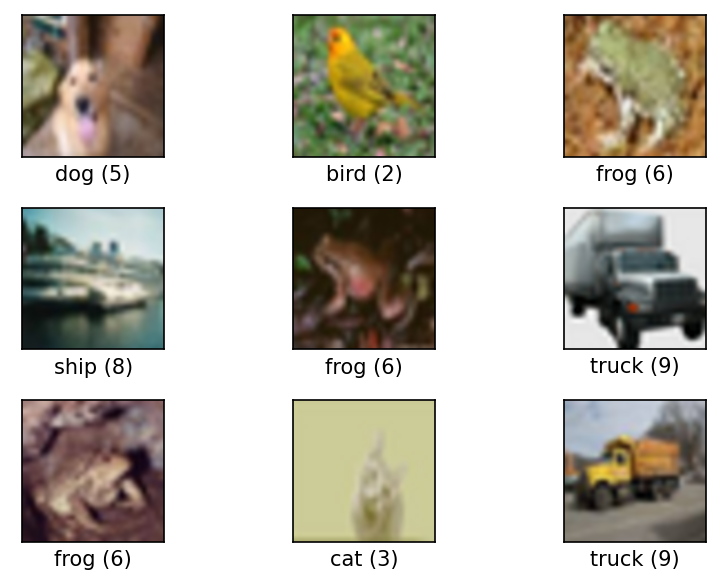

In [21]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

idx = random.sample([x for x in range(len(cifar))], 9)
images = [np.array(cifar[i][0]) for i in idx]
images = np.asarray(images)
targets = [cifar[i][1] for i in idx]

plot_images(images, targets, label_names=label_names)

Encore une fois, on désire obtenir des tensors de notre dataset.

In [22]:
cifar.transform = ToTensor()
cifar_test.transform = ToTensor()

#### Exercices

- Pour répondre aux questions suivantes, vous avez le contenu de ces 3 cellules.

In [23]:
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 47.28 - Val acc: 46.68 - Train loss: 1.4742 - Val loss: 1.4994
Epoch 1 - Train acc: 55.46 - Val acc: 52.82 - Train loss: 1.2453 - Val loss: 1.3069
Epoch 2 - Train acc: 62.76 - Val acc: 58.55 - Train loss: 1.0639 - Val loss: 1.1754
Epoch 3 - Train acc: 66.64 - Val acc: 61.69 - Train loss: 0.9505 - Val loss: 1.1067
Epoch 4 - Train acc: 68.22 - Val acc: 61.72 - Train loss: 0.9083 - Val loss: 1.1124


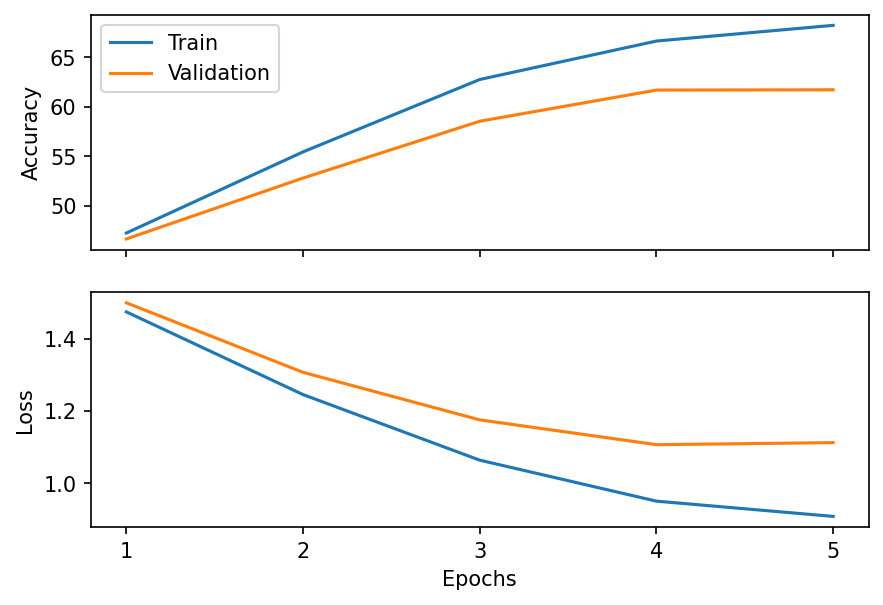

In [24]:
history.display()

In [25]:
test(model, cifar_test, batch_size, use_gpu=True)

Test acc: 62.28 - Test loss: 1.0973


(62.28, 1.0972871579182375)

### Effet du nombre d'epochs

#### Exercice

- Modifiez le nombre d'epochs et observez les performances du réseau.

#### Questions

- Que se passe-t-il s'il est trop petit?
- Que se passe-t-il s'il est trop grand?

In [26]:
epochs = [i for i in range(5, 105, 50)]
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

epoch_2_test = {}

for epoch in epochs:
    print('-'*50, f"epochs: {epoch}", '-'*50)
    history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
#     history.display()
    test_acc, test_loss = test(model, cifar_test, batch_size, use_gpu=True)
    epoch_2_test[epoch] = dict(history=history, test_acc=test_acc, test_loss=test_loss)

-------------------------------------------------- epochs: 5 --------------------------------------------------
Epoch 0 - Train acc: 47.12 - Val acc: 46.19 - Train loss: 1.5158 - Val loss: 1.5420
Epoch 1 - Train acc: 57.44 - Val acc: 54.80 - Train loss: 1.2225 - Val loss: 1.2883
Epoch 2 - Train acc: 64.57 - Val acc: 60.15 - Train loss: 1.0198 - Val loss: 1.1215
Epoch 3 - Train acc: 70.33 - Val acc: 64.89 - Train loss: 0.8618 - Val loss: 1.0055
Epoch 4 - Train acc: 73.01 - Val acc: 65.66 - Train loss: 0.7813 - Val loss: 1.0037
Test acc: 65.16 - Test loss: 1.0002
-------------------------------------------------- epochs: 25 --------------------------------------------------
Epoch 0 - Train acc: 72.21 - Val acc: 63.26 - Train loss: 0.7935 - Val loss: 1.0579
Epoch 1 - Train acc: 80.27 - Val acc: 68.71 - Train loss: 0.5880 - Val loss: 0.9605
Epoch 2 - Train acc: 82.36 - Val acc: 68.00 - Train loss: 0.5201 - Val loss: 0.9565
Epoch 3 - Train acc: 86.88 - Val acc: 68.48 - Train loss: 0.3962 - 

Epoch 16 - Train acc: 95.05 - Val acc: 63.50 - Train loss: 0.2704 - Val loss: 6.0463
Epoch 17 - Train acc: 93.76 - Val acc: 62.71 - Train loss: 0.3547 - Val loss: 6.0410
Epoch 18 - Train acc: 94.73 - Val acc: 63.11 - Train loss: 0.2824 - Val loss: 6.0652
Epoch 19 - Train acc: 96.30 - Val acc: 63.04 - Train loss: 0.1812 - Val loss: 5.8014
Epoch 20 - Train acc: 95.63 - Val acc: 63.38 - Train loss: 0.2480 - Val loss: 6.7036
Epoch 21 - Train acc: 96.34 - Val acc: 64.16 - Train loss: 0.1937 - Val loss: 6.3984
Epoch 22 - Train acc: 94.73 - Val acc: 62.40 - Train loss: 0.2931 - Val loss: 6.3329
Epoch 23 - Train acc: 93.77 - Val acc: 62.10 - Train loss: 0.3395 - Val loss: 6.1270
Epoch 24 - Train acc: 91.52 - Val acc: 61.24 - Train loss: 0.5195 - Val loss: 6.3724
Epoch 25 - Train acc: 91.48 - Val acc: 61.78 - Train loss: 0.6254 - Val loss: 7.6151
Epoch 26 - Train acc: 89.85 - Val acc: 60.72 - Train loss: 0.8713 - Val loss: 8.5440
Epoch 27 - Train acc: 94.83 - Val acc: 62.18 - Train loss: 0.3205

Epoch 46 - Train acc: 91.08 - Val acc: 56.30 - Train loss: 0.9443 - Val loss: 13.6835
Epoch 47 - Train acc: 89.79 - Val acc: 58.29 - Train loss: 1.2631 - Val loss: 14.2688
Epoch 48 - Train acc: 89.07 - Val acc: 55.62 - Train loss: 0.9600 - Val loss: 11.4598
Epoch 49 - Train acc: 91.36 - Val acc: 59.45 - Train loss: 1.2253 - Val loss: 16.7390
Epoch 50 - Train acc: 89.40 - Val acc: 57.18 - Train loss: 1.3744 - Val loss: 15.3403
Epoch 51 - Train acc: 87.60 - Val acc: 55.62 - Train loss: 1.3142 - Val loss: 12.9961
Epoch 52 - Train acc: 91.06 - Val acc: 59.31 - Train loss: 1.1342 - Val loss: 15.6747
Epoch 53 - Train acc: 89.68 - Val acc: 57.45 - Train loss: 1.2616 - Val loss: 14.1448
Epoch 54 - Train acc: 89.01 - Val acc: 57.17 - Train loss: 1.3058 - Val loss: 14.6900
Epoch 55 - Train acc: 89.01 - Val acc: 56.76 - Train loss: 1.0723 - Val loss: 12.4323
Epoch 56 - Train acc: 88.78 - Val acc: 55.99 - Train loss: 1.2917 - Val loss: 14.5368
Epoch 57 - Train acc: 89.76 - Val acc: 56.64 - Train l

### Effet de la taille de la batch

#### Exercice

- Modifiez la taille de la batch et observez l'utilisation de la carte graphique. 

#### Questions

- Sur quoi est-ce que la taille de la batch semble avoir le plus d'impact? 

    **Note**: Pour pouvoir observer les changements au niveau de l'utilisation de la mémoire du GPU, il est préférable de redémarrer le kernel du notebook entre chaque tentative (dans le menu Kernel). Si vous prenez ce chemin, n'oubliez pas d'exécuter les cellules nécessaires plus haut dans le notebook (les imports, les fonctions train, validate, etc.).
    
- Est-ce qu'elle impacte les performances?
- Que peut-on conclure sur la taille de batch optimale?

     **Note**: on ne demande pas de trouver cette taille optimale mais de commenter sur la manière dont on la trouverait.

In [27]:
def check_memory_usage():
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print(f'Allocated: {round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1)} GB')
    print(f'Cached:   {round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1)} GB')
    print(f"Memory summary: \n{torch.cuda.memory_summary()}")

GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:   0.1 GB
Memory summary: 
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    5732 KB |   64099 KB |   10895 GB |   10895 GB |
|       from large pool |    4218 KB |   63110 KB |    9817 GB |    9817 GB |
|       from small pool |    1514 KB |    4790 KB |    1078 GB |    1078 GB |
|---------------------------------------------------------------------------|
| Active memory         |    5732 KB |   64099 KB |   10

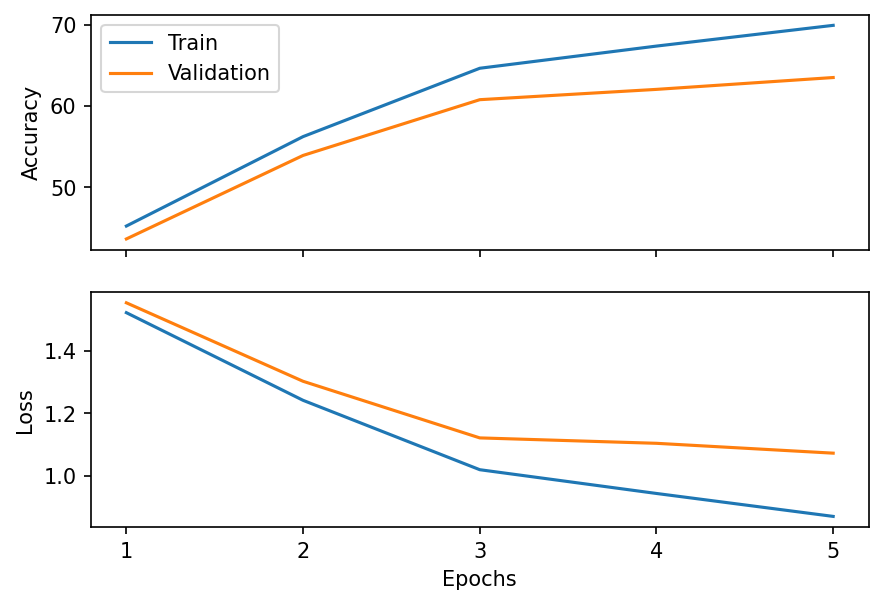

Test acc: 63.34 - Test loss: 1.0687
GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:   0.1 GB
Memory summary: 
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    5732 KB |   64099 KB |   11125 GB |   11125 GB |
|       from large pool |    4218 KB |   63110 KB |   10024 GB |   10024 GB |
|       from small pool |    1514 KB |    4790 KB |    1100 GB |    1100 GB |
|---------------------------------------------------------------------------|
| Active memory     

In [28]:
check_memory_usage()
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)
check_memory_usage()

GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:   0.1 GB
Memory summary: 
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    5732 KB |   64099 KB |   11125 GB |   11125 GB |
|       from large pool |    4218 KB |   63110 KB |   10024 GB |   10024 GB |
|       from small pool |    1514 KB |    4790 KB |    1100 GB |    1100 GB |
|---------------------------------------------------------------------------|
| Active memory         |    5732 KB |   64099 KB |   11

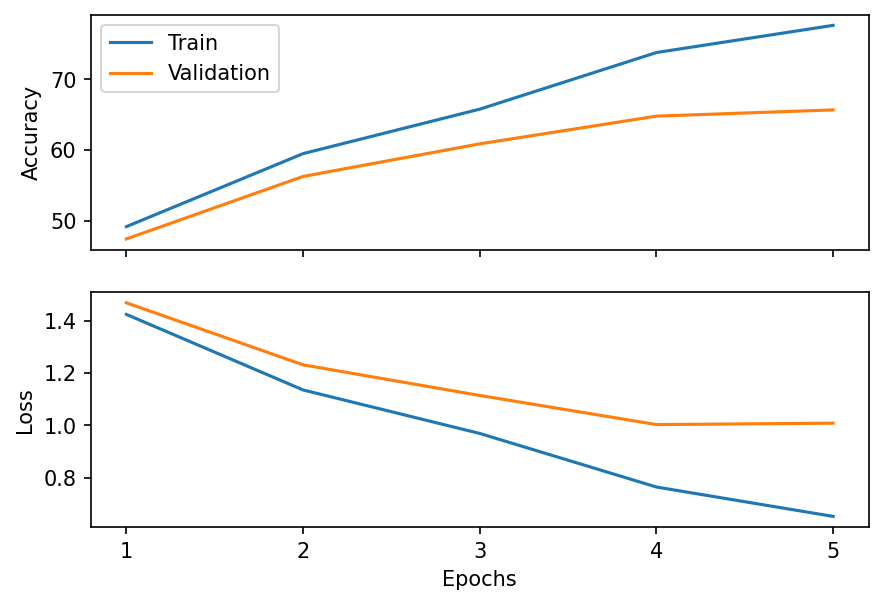

Test acc: 66.49 - Test loss: 1.0076
GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:   0.1 GB
Memory summary: 
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    5732 KB |   64099 KB |   11377 GB |   11377 GB |
|       from large pool |    4218 KB |   63110 KB |   10220 GB |   10220 GB |
|       from small pool |    1514 KB |    4885 KB |    1157 GB |    1157 GB |
|---------------------------------------------------------------------------|
| Active memory     

In [29]:
check_memory_usage()
epoch = 5
batch_size = 32
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)
check_memory_usage()

### Effet du taux d'apprentissage (lr)

Finalement, observez l'impact du taux d'apprentissage sur l'entraînement.

#### Questions

- Que se passe-t-il s'il est trop grand?
- S'il est trop petit?

Epoch 0 - Train acc: 10.14 - Val acc: 9.43 - Train loss: 2.3005 - Val loss: 2.3011
Epoch 1 - Train acc: 10.14 - Val acc: 9.43 - Train loss: 2.2984 - Val loss: 2.2990
Epoch 2 - Train acc: 10.17 - Val acc: 9.46 - Train loss: 2.2957 - Val loss: 2.2964
Epoch 3 - Train acc: 11.43 - Val acc: 10.92 - Train loss: 2.2920 - Val loss: 2.2928
Epoch 4 - Train acc: 13.72 - Val acc: 13.44 - Train loss: 2.2865 - Val loss: 2.2873


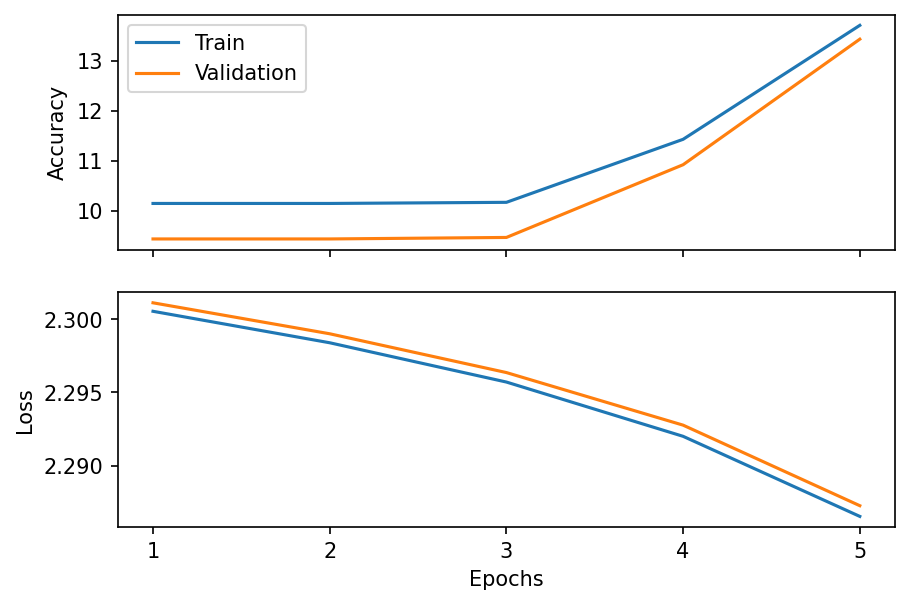

Test acc: 13.86 - Test loss: 2.2864


(13.86, 2.2863971974439683)

In [39]:
epoch = 5
batch_size = 64
learning_rate = 1e-3

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 40.48 - Val acc: 39.60 - Train loss: 1.7288 - Val loss: 1.7511
Epoch 1 - Train acc: 57.49 - Val acc: 55.23 - Train loss: 1.2186 - Val loss: 1.2791
Epoch 2 - Train acc: 63.91 - Val acc: 60.06 - Train loss: 1.0253 - Val loss: 1.1263
Epoch 3 - Train acc: 68.53 - Val acc: 63.43 - Train loss: 0.8943 - Val loss: 1.0489
Epoch 4 - Train acc: 73.03 - Val acc: 65.59 - Train loss: 0.7900 - Val loss: 1.0009


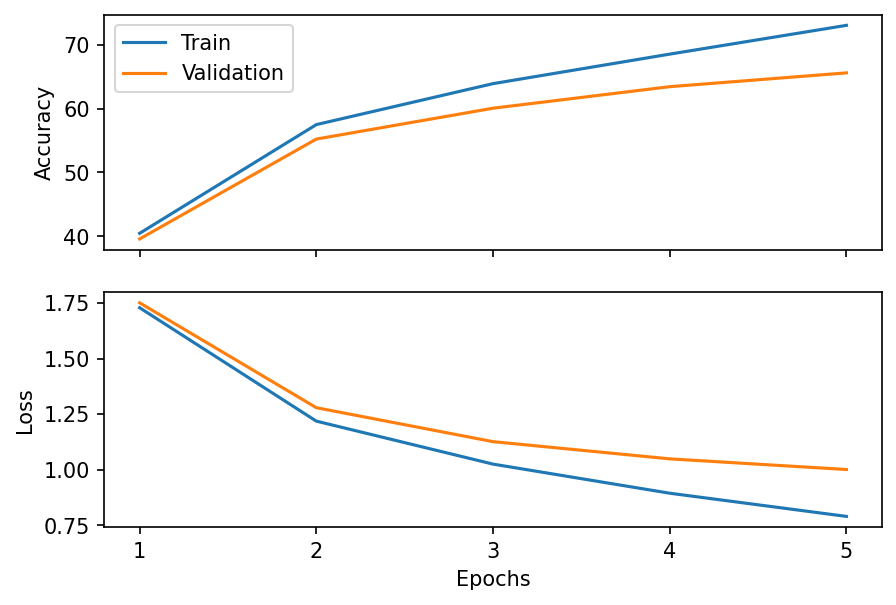

Test acc: 65.53 - Test loss: 1.0010


(65.53, 1.0010301239171606)

In [40]:
epoch = 5
batch_size = 64
learning_rate = 1e-1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Défi

- Modifiez les hyperparamètres pour améliorer les performances du réseau.<br>
Essayez d'obtenir plus de 65% en test.

- Vous pouvez aussi tenter de battre l'état de l'art: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130

Epoch 0 - Train acc: 23.76 - Val acc: 23.84 - Train loss: 2.1449 - Val loss: 2.1463
Epoch 1 - Train acc: 30.33 - Val acc: 31.01 - Train loss: 1.9575 - Val loss: 1.9545
Epoch 2 - Train acc: 34.54 - Val acc: 34.66 - Train loss: 1.8519 - Val loss: 1.8570
Epoch 3 - Train acc: 40.34 - Val acc: 40.20 - Train loss: 1.7052 - Val loss: 1.7098
Epoch 4 - Train acc: 42.73 - Val acc: 42.22 - Train loss: 1.6217 - Val loss: 1.6375
Epoch 5 - Train acc: 44.06 - Val acc: 42.88 - Train loss: 1.5828 - Val loss: 1.6030
Epoch 6 - Train acc: 47.05 - Val acc: 45.79 - Train loss: 1.4985 - Val loss: 1.5176
Epoch 7 - Train acc: 48.68 - Val acc: 47.38 - Train loss: 1.4580 - Val loss: 1.4854
Epoch 8 - Train acc: 48.09 - Val acc: 46.50 - Train loss: 1.4679 - Val loss: 1.5008
Epoch 9 - Train acc: 47.87 - Val acc: 46.63 - Train loss: 1.4671 - Val loss: 1.5023
Epoch 10 - Train acc: 51.24 - Val acc: 49.98 - Train loss: 1.4066 - Val loss: 1.4402
Epoch 11 - Train acc: 53.65 - Val acc: 51.87 - Train loss: 1.3219 - Val los

Epoch 97 - Train acc: 93.48 - Val acc: 67.26 - Train loss: 0.2142 - Val loss: 1.2839
Epoch 98 - Train acc: 95.17 - Val acc: 67.67 - Train loss: 0.1816 - Val loss: 1.2689
Epoch 99 - Train acc: 93.51 - Val acc: 66.87 - Train loss: 0.2122 - Val loss: 1.3347


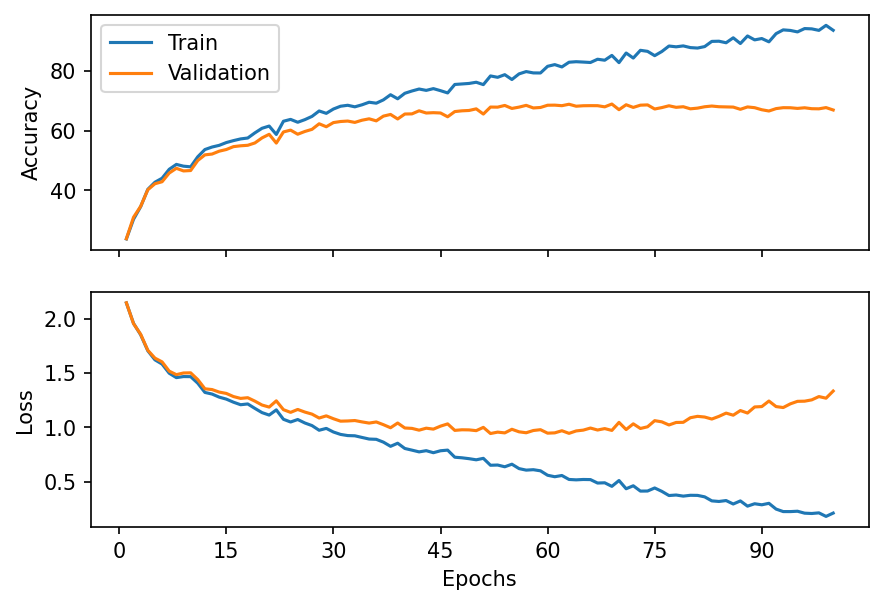

Test acc: 67.30 - Test loss: 1.3254


(67.30000000000001, 1.325421129062677)

In [43]:
epoch = 100
batch_size = 64
learning_rate = 0.5e-2

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

## Utilisation d'une librairie pour l'entraînement

Comme vous l'avez peut-être remarqué, les fonctions `train` et `test` que nous avons utilisées sont bien pratiques. Il existe différentes librairies nous permettant de ne pas devoir définir ces fonctions pour chacun de nos projets. Lorsqu'approprié, nous utiliserons une de ces librairies dans les laboratoires de ce cours. Nous avons choisi d'utiliser la librairie [Poutyne](https://poutyne.org/) qui est développée ici même à l'Université Laval.

Définissons nos hyperparamètres usuels.

In [32]:
epoch = 5
batch_size = 64
learning_rate = 0.1

Poutyne peut prendre en entrée des Numpy arrays ou des tenseurs via sa méthode `fit` ou bien des objets qui sont itérables comme des `DataLoader` de PyTorch via sa méthode `fit_generator`. Définissons donc des `DataLoader` comme le font les fonctions `train` et `test`.

In [33]:
train_loader, valid_loader = train_valid_loaders(cifar, batch_size=batch_size)
test_loader = DataLoader(cifar_test, batch_size=batch_size)

Importons Poutyne.

In [34]:
import poutyne as pt

Procédons maintenant à l'entraînement. La principale classe de Poutyne est la classe [`Model`](https://poutyne.org/model.html) qui nous servira à effectuer l'entraînement. Également, n'hésitez pas à jeter un coup d'oeil à la classe [`Experiment`](https://poutyne.org/experiment.html) qui permet de sauvegarder automatiquement un tas d'information comme des points de sauvegarde (checkpoints) et des logs.

Epoch: 1/5 Step: 625/625 100.00% |████████████████████|7.97s loss: 1.824408 acc: 34.010000 val_loss: 1.479447 val_acc: 48.010000
Epoch: 2/5 Step: 625/625 100.00% |████████████████████|8.00s loss: 1.383156 acc: 50.557500 val_loss: 1.324278 val_acc: 53.240000
Epoch: 3/5 Step: 625/625 100.00% |████████████████████|7.96s loss: 1.198959 acc: 57.647500 val_loss: 1.158315 val_acc: 59.560000
Epoch: 4/5 Step: 625/625 100.00% |████████████████████|8.01s loss: 1.045270 acc: 63.190000 val_loss: 1.086924 val_acc: 62.190000
Epoch: 5/5 Step: 625/625 100.00% |████████████████████|7.98s loss: 0.921725 acc: 67.947500 val_loss: 1.126274 val_acc: 62.020000


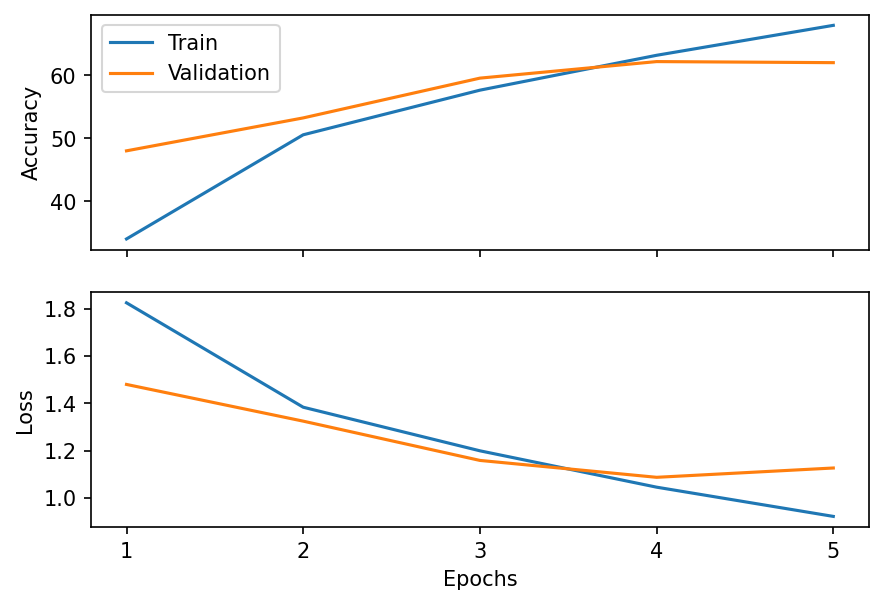

test_loss: 1.1349 test_acc: 62.07


In [35]:
# On instance notre réseau ainsi que l'optimiseur comme à l'habitude.
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# On crée un objet Model de Poutyne avec la fonction de perte et les métriques souhaitées.
model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

# Comme dit précedemment, on utilise la méthode `fit_generator` pour procéder à l'entraînement.
history = model.fit_generator(train_loader, valid_loader, epochs=epoch)

# La classe History peut aussi prendre un historique de Poutyne en entrée.
History(history).display()

# Finalement, on utilise la fonction evaluate_generator pour calculer la perte et l'exactitude sur
# notre ensemble de test.
test_loss, test_acc = model.evaluate_generator(test_loader)
print('test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

### Pour aller plus loin

Un aspect intéressant de Poutyne est l'utilisation de [callbacks](https://poutyne.org/callbacks.html) qui permettent d'effectuer des actions pendant l'entraînement. Dans l'exemple suivant, on utilise deux types de callbacks: un permettant de faire des points de sauvegarde et l'autre permettant de logger dans un CSV les statistiques d'entraînement.

In [36]:
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

os.makedirs('logs', exist_ok=True)

callbacks = [
    # Effectue des points de sauvegarde après chaque epoch dans le fichier last_epoch.ckpt.
    pt.ModelCheckpoint('logs/last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

    # Effectue des points de sauvegarde à chaque fois qu'il y a amélioration de l'exactitude
    # en validation. Le nom du fichier va contenir le numéro de l'epoch correspondante.
    pt.ModelCheckpoint('logs/best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

    # Sauvegarde toutes les stats affichés dans un fichier CSV.
    pt.CSVLogger('logs/log.csv'),
]

model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

history = model.fit_generator(train_loader, valid_loader, epochs=epoch, callbacks=callbacks)

Epoch: 1/5 Step: 625/625 100.00% |████████████████████|7.96s loss: 1.903860 acc: 30.807500 val_loss: 1.525224 val_acc: 45.500000
Epoch 1: val_acc improved from -inf to 45.50000, saving file to logs/best_epoch_1.ckpt
Epoch: 2/5 Step: 625/625 100.00% |████████████████████|8.00s loss: 1.392823 acc: 50.480000 val_loss: 1.310353 val_acc: 53.030000
Epoch 2: val_acc improved from 45.50000 to 53.03000, saving file to logs/best_epoch_2.ckpt
Epoch: 3/5 Step: 625/625 100.00% |████████████████████|7.96s loss: 1.163305 acc: 59.200000 val_loss: 1.098765 val_acc: 61.180000
Epoch 3: val_acc improved from 53.03000 to 61.18000, saving file to logs/best_epoch_3.ckpt
Epoch: 4/5 Step: 625/625 100.00% |████████████████████|7.96s loss: 1.000521 acc: 65.185000 val_loss: 1.002535 val_acc: 65.310000
Epoch 4: val_acc improved from 61.18000 to 65.31000, saving file to logs/best_epoch_4.ckpt
Epoch: 5/5 Step: 625/625 100.00% |████████████████████|8.02s loss: 0.886742 acc: 69.432500 val_loss: 0.944708 val_acc: 67.21

Une fois l'entraînement effectué, on peut aller lire le fichier de log CSV avec la librairie pandas.

In [37]:
pd.read_csv('logs/log.csv')

,epoch,time,lr,loss,acc,val_loss,val_acc
0,1,7.958005,0.1,1.903860,30.8075,1.525224,45.50
1,2,7.998328,0.1,1.392823,50.4800,1.310353,53.03
2,3,7.964577,0.1,1.163305,59.2000,1.098765,61.18
3,4,7.963975,0.1,1.000521,65.1850,1.002535,65.31
4,5,8.024231,0.1,0.886742,69.4325,0.944708,67.21


Étant donné le court entraînement, on devrait avoir obtenu des points de sauvegarde pour chacun des epochs. Amusez vous à charger différents epochs et à regarder l'impact sur l'ensemble de test.

In [38]:
model.load_weights('logs/best_epoch_4.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 4: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

model.load_weights('logs/best_epoch_5.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 5: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

Epoch 4: test_loss: 1.0010 test_acc: 65.89
Epoch 5: test_loss: 0.9373 test_acc: 67.62
